In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA   
# Import ARIMA model for time series forecasting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  
# Import functions to plot ACF and PACF for model identification


In [3]:
# 1️⃣ Simulate realistic sales data
np.random.seed(42)
dates = pd.date_range(start="2018-01-01", periods=60, freq="M")
trend = np.linspace(100, 200, 60)
seasonality = 10 * np.sin(2 * np.pi * dates.month / 12)
noise = np.random.normal(0, 5, 60)
sales = trend + seasonality + noise
df = pd.DataFrame({"Sales": sales}, index=dates)

df.head()

,Sales
2018-01-31,107.483571
2018-02-28,109.663848
2018-03-31,116.628273
2018-04-30,121.360149
2018-05-31,110.608894


In [4]:
df.shape

(60, 1)

In [5]:
# 2️⃣ Differencing to achieve stationarity
df["Sales_diff"] = df["Sales"].diff(12)  # seasonal differencing
df_stationary = df["Sales_diff"].dropna()
df_stationary.head()

2019-01-31    19.065224
2019-02-28    11.463903
2019-03-31     8.475951
2019-04-30     9.912396
2019-05-31    16.445594
Freq: M, Name: Sales_diff, dtype: float64

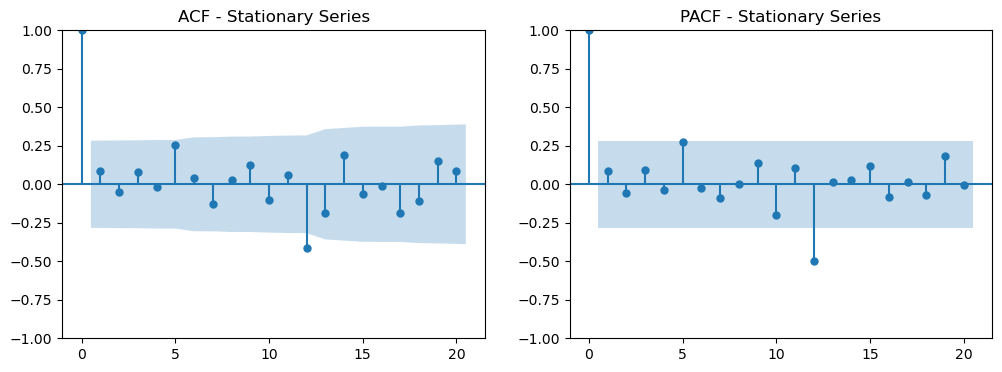

In [6]:
# 3️⃣ Look at ACF/PACF for p & q selection
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(df_stationary, lags=20, ax=axes[0])
axes[0].set_title("ACF - Stationary Series")
plot_pacf(df_stationary, lags=20, method='ywm', ax=axes[1])
axes[1].set_title("PACF - Stationary Series")
plt.show()


In [7]:
# From plots, suppose we choose p=1, d=1, q=1 (example)
# 4️⃣ Fit ARIMA model
model = ARIMA(df["Sales"], order=(1, 1, 1))
model_fit = model.fit()


In [8]:

# 5️⃣ Model summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   60
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -199.722
Date:                Sat, 23 Aug 2025   AIC                            405.444
Time:                        22:20:45   BIC                            411.676
Sample:                    01-31-2018   HQIC                           407.877
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1516      1.032     -0.147      0.883      -2.175       1.872
ma.L1          0.0310      1.025      0.030      0.976      -1.979       2.041
sigma2        51.0054     12.314      4.142      0.0

 Model Used:

ARIMA(1,1,1) → This means the model has:

1 Auto-Regressive (AR) term,

1 Differencing (I),

1 Moving Average (MA) term.

Coefficients (ar.L1, ma.L1, sigma²):

ar.L1 and ma.L1 → These are the weights for AR and MA parts.

Here both are not statistically significant (p-values 0.883, 0.976 > 0.05).

So, they don’t add much predictive power.



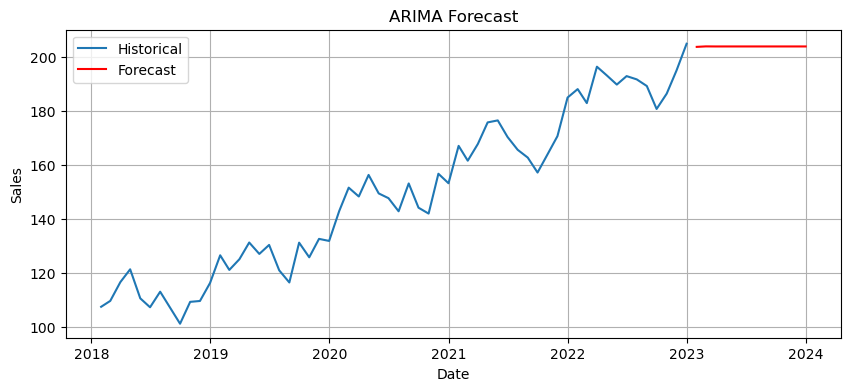

In [9]:
# 6️⃣ Forecast next 12 months
forecast = model_fit.forecast(steps=12)
plt.figure(figsize=(10,4))
plt.plot(df.index, df["Sales"], label="Historical")
plt.plot(pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(),
                       periods=12, freq="M"),
         forecast, label="Forecast", color="red")
plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()


### Why your line is flat

You differenced the data and then fit a non-seasonal ARIMA. 

After differencing, the model often learns “changes ≈ 0”, so the integrated forecast becomes a constant level → flat line.

No seasonal AR/MA terms were included, so any yearly pattern can’t reappear in the forecast.

If the fitted AR/MA coefficients are small or insignificant, 

the model behaves close to ARIMA(0,1,0) (a random walk), whose mean forecast is flat.



Flat ARIMA forecasts usually mean no drift and no seasonal terms; the model learned that future changes average to zero.

Adding drift lets the model extend a linear trend.

Adding seasonal terms (SARIMA) brings back the yearly pattern in the forecast.

Always check residuals: if they still show seasonality, your model needs seasonal terms.

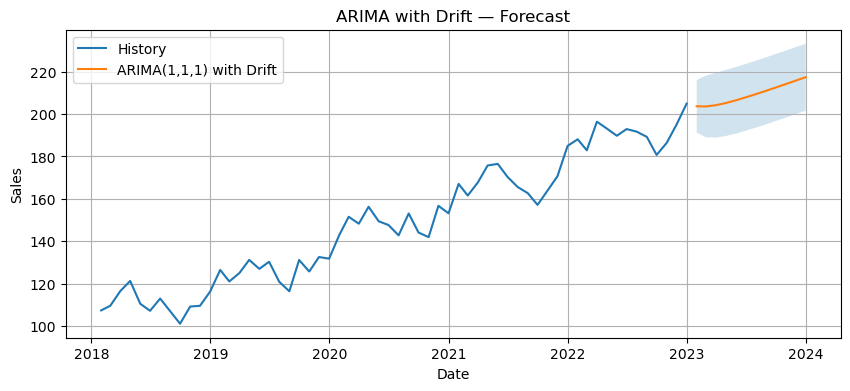

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# --- Simulate the same 5-year monthly series ---
np.random.seed(42)
dates = pd.date_range(start="2018-01-01", periods=60, freq="M")
trend = np.linspace(100, 200, 60)
seasonality = 10 * np.sin(2 * np.pi * dates.month / 12)
noise = np.random.normal(0, 5, 60)
sales = trend + seasonality + noise

y = pd.Series(sales, index=dates)

# --- ARIMA with linear trend (acts like drift when d=1) ---
model = ARIMA(y, order=(1,1,1), trend='t')   # 't' = linear trend
fit = model.fit()

# Forecast next 12 months
fc = fit.get_forecast(12).summary_frame()

# Plot
plt.figure(figsize=(10,4))
plt.plot(y.index, y, label="History")
plt.plot(fc.index, fc["mean"], label="ARIMA(1,1,1) with Drift")
plt.fill_between(fc.index, fc["mean_ci_lower"], fc["mean_ci_upper"], alpha=0.2)
plt.title("ARIMA with Drift — Forecast")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.grid(True); plt.legend(); plt.show()


The forecast will no longer be flat.

It will extend the upward trend into the future (linear slope).

Still no seasonal wiggles (that needs SARIMA).

### Use SARIMA to capture seasonality (recommended here)

Model the yearly pattern directly. Do not manually seasonal-difference first; let the model do D=1 at period 12.

C:\Users\askpr\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\askpr\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


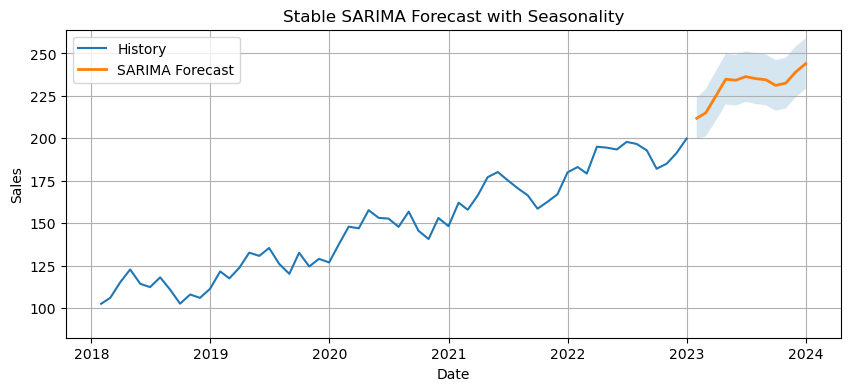

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Simulate data: clear trend + seasonality + noise ---
np.random.seed(42)
dates = pd.date_range(start="2018-01-01", periods=60, freq="M")
trend = np.linspace(100, 200, 60)                                  # upward trend
seasonality = 10 * np.sin(2 * np.pi * (dates.month-1) / 12)        # yearly cycle
noise = np.random.normal(0, 5, 60)
y = pd.Series(trend + seasonality + noise, index=dates)

# --- Fit a stable SARIMA ---
# Keep non-seasonal part simple, let seasonal differencing handle seasonality
model = SARIMAX(
    y,
    order=(1,0,0),                 # simple AR(1) on levels
    seasonal_order=(1,1,1,12),     # SARIMA seasonal structure
    trend='t',                     # linear trend (drift)
    enforce_stationarity=True,
    enforce_invertibility=True
)
fit = model.fit(disp=False)

# --- Forecast next 12 months ---
fc = fit.get_forecast(12).summary_frame()   # mean, and mean_ci_lower/upper

# --- Plot (avoid auto-scaling issues) ---
plt.figure(figsize=(10,4))
plt.plot(y.index, y.values, label="History")
plt.plot(fc.index, fc["mean"].values, label="SARIMA Forecast", linewidth=2)

# Draw confidence band but clamp the y-limits so history is visible
plt.fill_between(fc.index, fc["mean_ci_lower"].values, fc["mean_ci_upper"].values, alpha=0.18)

# Keep the y-range around your actual data, not the widest CI
ymin = min(y.min(), fc["mean"].min()) - 20
ymax = max(y.max(), fc["mean"].max()) + 20
plt.ylim(ymin, ymax)

# Make y ticks plain (no scientific notation)
plt.ticklabel_format(style='plain', axis='y')

plt.title("Stable SARIMA Forecast with Seasonality")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.grid(True); plt.legend(); plt.show()


Model A: AIC = 240.76
Model B: AIC = 1514.60
Model C: AIC = 1519.63

Best model: Model A with AIC = 240.76


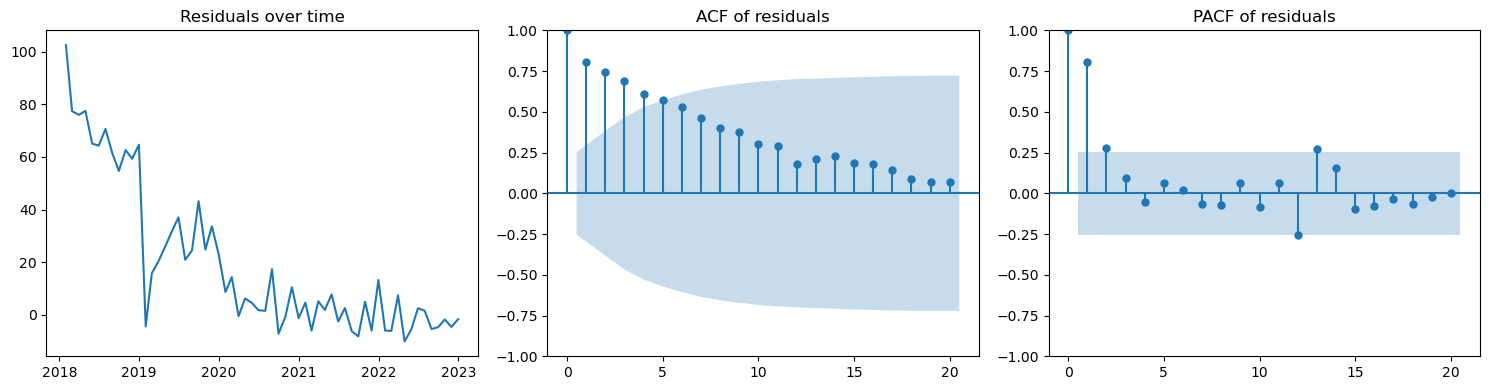

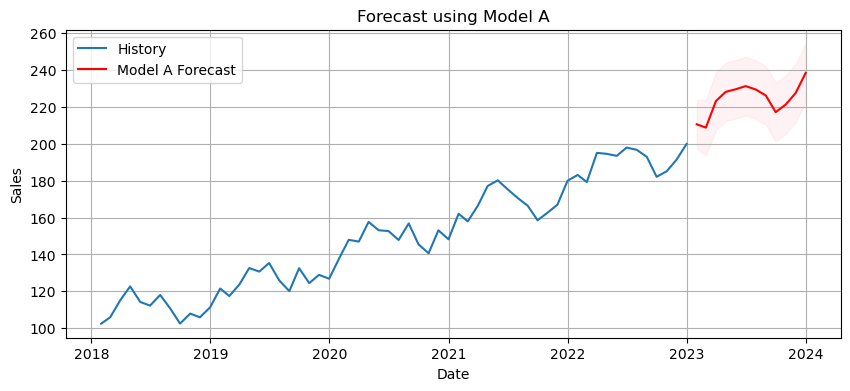

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- Simulated dataset (trend + seasonality + noise) ---
np.random.seed(42)
dates = pd.date_range(start="2018-01-01", periods=60, freq="M")
trend = np.linspace(100, 200, 60)
seasonality = 10 * np.sin(2 * np.pi * (dates.month-1) / 12)
noise = np.random.normal(0, 5, 60)
y = pd.Series(trend + seasonality + noise, index=dates)

# --- Define candidate SARIMA models ---
candidates = {
    "Model A": ( (1,0,0), (1,1,0,12) ),
    "Model B": ( (1,0,0), (1,1,1,12) ),
    "Model C": ( (0,0,1), (0,1,1,12) )
}

results = {}

# --- Fit and compare AIC ---
for name, (order, sorder) in candidates.items():
    
    model = SARIMAX(y, order=order, seasonal_order=sorder, trend='t',
                enforce_stationarity=False, enforce_invertibility=False)
    fit = model.fit(disp=False, maxiter=500, method="lbfgs")

    results[name] = fit
    print(f"{name}: AIC = {fit.aic:.2f}")

# --- Pick best (lowest AIC) ---
best_model_name = min(results, key=lambda k: results[k].aic)
best_fit = results[best_model_name]
print(f"\nBest model: {best_model_name} with AIC = {best_fit.aic:.2f}")

# --- Residual diagnostics for best model ---
resid = best_fit.resid

fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].plot(resid)
axes[0].set_title("Residuals over time")
plot_acf(resid, lags=20, ax=axes[1])
axes[1].set_title("ACF of residuals")

plot_pacf(resid, lags=20, ax=axes[2], method="ywm")  # 👈 fixed warning
axes[2].set_title("PACF of residuals")
plt.tight_layout()
plt.show()

# --- Forecast from best model ---
fc = best_fit.get_forecast(12).summary_frame()





plt.figure(figsize=(10,4))
plt.plot(y.index, y.values, label="History")
plt.plot(fc.index, fc["mean"].values, label=f"{best_model_name} Forecast", color="red")
plt.fill_between(fc.index, fc["mean_ci_lower"].values, fc["mean_ci_upper"].values, alpha=0.2, color="pink")
plt.title(f"Forecast using {best_model_name}")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.grid(True); plt.legend(); plt.show()


AIC (Akaike Information Criterion) measures model fit vs. complexity.

A lower AIC means the model explains the data well without being unnecessarily complex, so we prefer the model with the smallest AIC.

We don’t just guess SARIMA orders — we compare models systematically.

AIC helps us balance fit and complexity. Lower AIC usually means better generalization.

Even if AIC is good, we must check residuals. If residuals show autocorrelation, the model missed some structure.

Only when residuals look like white noise do we trust the forecast.